## Algorithmic Bias

#### When training a model, the balance of a dataset plays a key role in the results and the real accuracy of our later results. If the minority class occupies only 5% of the dataset, one could achieve 95% accuracy after training by simply predicting the majority class 100% of the time. In the field of cancer diagnosis, where positive results are (thankfully) very much in the minority, a biased algorithm could be fatal. Finding computationally efficient strategies to rectify this issue is hence important. 

In [42]:
import numpy as np
import pandas as pd
import math
import statistics
from collections import Counter
from numpy import unique
from sklearn.model_selection import GridSearchCV


surv = pd.read_csv('survival.csv')
surv['Survived'] = 'GE5'
surv.loc[surv['Class']==2,'Survived']='L5'
surv.head()


,Age,Year,NNodes,Class,Survived
0,30,64,1,1,GE5
1,30,62,3,1,GE5
2,30,65,0,1,GE5
3,31,59,2,1,GE5
4,31,65,4,1,GE5


In [23]:
vc = surv['Survived'].value_counts()
vc

GE5    225
L5      81
Name: Survived, dtype: int64

In [25]:
print("Missing Values")
print(surv.isnull().sum().sort_values(ascending = False))

Missing Values
Survived    0
Class       0
NNodes      0
Year        0
Age         0
dtype: int64


In [26]:
y = surv.pop('Survived').values
surv.pop('Class')
X = surv.values
X.shape, y.shape

((306, 3), (306,))

In [27]:
min_class = (Counter(y)['L5']/len(y))
print("Minority class : %0.2f" % min_class)

Minority class : 0.26


The survival dataset contains two classes, L5 and GE5, corresponding to those who survive less than 5 years after surgery, and those who survive 5+ years after surgery. L5 is the minority class, at ~26%.
In the next cell we will be training four different classifiers with this data. 

## Models

In [28]:
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import plot_precision_recall_curve

models = {}
models['Gradient Boosting'] = GradientBoostingClassifier(random_state=1)
models['Decision Tree'] = DecisionTreeClassifier(criterion='entropy')
models['k Nearest Neighbors'] = KNeighborsClassifier(n_neighbors=3)  
models['Logistic Regression'] = LogisticRegression(max_iter=10000, solver = 'sag', random_state=0)


In the below cell, the "evaluate_model" function, calculates a number of metrics by which we can evaluate the classifiers. The following measures are being tracked:
- Bias, which is measured as one minus the number of predictions of the minority class, divided by the number of actual members of the minority class. Therefore a perfect prediction of the minority class will result in bias of 0.
- Accuracy, meaning the percentage of correct predictions. 
- Precision, meaning the proportion of retrieved results that are relevant.
- Recall, meaning the true positive rate.
- F1-measure meaning the harmonic mean of precision and recall. 
- BER, the Balanced Error Rate.

In [56]:
def train_model(model, X_train, X_test, y_train, y_test):
    y_pred = model.fit(X_train, y_train).predict(X_test)
    return (evaluate_model(y_pred, y_test))
    
def evaluate_model(y_pred, y_test):
    pred_neg = Counter(y_pred)['L5']
    pred_pos = len(y_pred) - pred_neg
    test_neg = Counter(y_test)['L5']
    bias = 1 - (pred_neg / test_neg)
    accuracy = accuracy_score(y_test, y_pred)
    minority_percent = pred_neg/len(y_pred)
    confusion = confusion_matrix(y_test, y_pred, labels=['L5', 'GE5'])
    precision = confusion[1][1] / (confusion[1][1] + confusion[0][1])
    recall = confusion[1][1] / (confusion[1][1] + confusion[1][0])
    f1 = f1_score(y_test, y_pred, pos_label='GE5')
    false_positive = confusion[0][1] / (confusion[0][1] + confusion[0][0])
    false_negative = confusion[1][0] / (confusion[1][0] + confusion[1][1])
    BER = statistics.mean([false_positive, false_negative])
    return [accuracy, bias, minority_percent, f1, precision, recall, false_positive, BER, confusion]



## Hold-Out Testing

As the dataset is quite limited in size, we will not be pursuing a train/validation/test split, and instead a simple 70/30 train/test split. The goal below is to establish a baseline of how Gradient Boosting, Decision Trees, kNN and Logistic Regression perform on this dataset, without modification.  

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state=0)
minority_class = (Counter(y_test)['L5']/len(y_test))
model_results = pd.DataFrame(columns=['Classifier', 'Accuracy','Bias','Predicted Minority', 'F1', 
                                      'Precision', 'Recall', 'False Positive', 'BER', 'Confusion Matrix'])
for i, m in enumerate(models):
    model_results.loc[i] = [m] + train_model(models[m], X_train, X_test, y_train, y_test)


In [31]:
pd.set_option('display.float_format','{:.2f}'.format)
model_results

,Classifier,Accuracy,Bias,Predicted Minority,F1,Precision,Recall,False Positive,BER,Confusion Matrix
0,Gradient Boosting,0.62,0.36,0.23,0.73,0.67,0.80,0.72,0.46,"[[10, 26], [13, 53]]"
1,Decision Tree,0.59,0.28,0.25,0.70,0.66,0.76,0.72,0.48,"[[10, 26], [16, 50]]"
2,k Nearest Neighbors,0.68,0.53,0.17,0.78,0.69,0.89,0.72,0.41,"[[10, 26], [7, 59]]"
3,Logistic Regression,0.65,0.83,0.06,0.78,0.66,0.95,0.92,0.48,"[[3, 33], [3, 63]]"


- All four models are showing bias, with Logistic Regression showing significantly the most bias.
- The accuracy for all four models falls between .60 and .68. A good aim would be a minimum accuracy of .7
- Precision between the models is also pretty steady, falling between .66 and .69.
- Recall is relatively high for all models, which when compared with the lower accuracy rates, again shows the bias of the classifiers towards the majority class. 
- The false positive rate is high for all four models, but especially for Logistic Regression
- The balanced error rate is falling between .40 and .48.
\
\
If we look at Logistic Regression, it is epitomising the issue at hand with regards to bias in unbalanced data. The model is almost never predicting the minority class, but because of the imbalance, this is actually equating to an excellent true positive rate. If we had only looked at the true positive rate, we may have inferred a false picture of a very accurate classifier. 

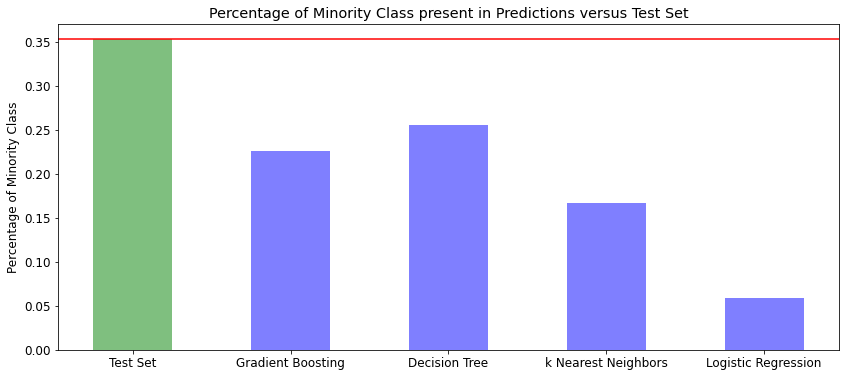

In [32]:
import matplotlib.pyplot as plt 
%matplotlib inline 
labels =  ['Test Set'] + list(model_results['Classifier'].values)
results = [minority_class] + list(model_results['Predicted Minority'].values)
plt.figure(figsize=(14,6))
plt.rc('font', size=12) 
plt.bar(labels, results, width=0.5, color=['green', 'blue', 'blue','blue','blue'],alpha=0.5)
plt.axhline(y=minority_class, color='red')
plt.ylabel('Percentage of Minority Class')
plt.title("Percentage of Minority Class present in Predictions versus Test Set")
plt.show()

Here we are plotting the presence of the minority class as a percentage of all the examples in the test set. The purple bars are predictions, and the green bar is the actual percentage present in the test set. The red horizontal line is the level at which the classifiers would ideally be predicting the minority class. None of the classifiers are nearing that level, but the decision tree classifier is performing the best of the four, and logistic regression the worst. 






## ROC-Curve

Another way of viewing the results is plotting a ROC, or receiver operating characteristic, curve. The roc curve plots the true positive rate, or sensitivity, against the false positive rate, or 1-specificity.

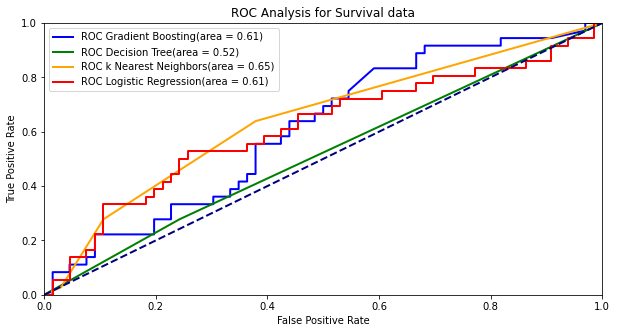

[('Gradient Boosting', 0.6125841750841751),
 ('Decision Tree', 0.5176767676767676),
 ('k Nearest Neighbors', 0.6460437710437711),
 ('Logistic Regression', 0.6144781144781145)]

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

plt.figure(figsize=(10,5))
lw = 2
roc = {}
scores = []
colours = ["blue", "green", "orange", "red"]
for i, m in enumerate(models):
    y_score = models[m].fit(X_train, y_train).predict_proba(X_test)
    fp, tp, t = roc_curve(y_test, y_score[:,1], pos_label='L5')
    roc[m] = [fp,tp,auc(fp, tp),m]
    scores.append((m, roc_auc_score(y_test, y_score[:,1])))
    plt.plot(fp, tp, color=colours[i],
             lw=lw, label=('ROC ' + m + '(area = %0.2f)' % auc(fp,tp)))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Analysis for Survival data')
plt.legend(loc="best")
plt.show()

scores

When looking at a ROC curve, what we are looking to consider is the area under the curve, or AUC. None of the classifiers have performed particularly well in this analysis. The ROC curve for the decision tree, is almost flat, with true positive rate and false positive rate growing steadily together. The other curves have more variation, with KNN seeming to perform best. It is hard to truly gauge performance by looking at a curve, so I have also scored the curves using roc_auc_score. Decision tree receives the lowest score, and KNN the best. Gradient Boosting and Logistic Regression receive very similar scores. 

## Cross Validation

We will now aim for a fuller view on the performance of the classifiers, using 10 fold cross validation. 

In [34]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred,labels=['L5','GE5'])[1, 1]
def tn(y_neg, y_pred): return confusion_matrix(y_neg, y_pred,labels=['L5','GE5'])[0, 0]
def fp(y_neg, y_pred): return confusion_matrix(y_neg, y_pred,labels=['L5','GE5'])[0, 1]
def fn(y_neg, y_pred): return confusion_matrix(y_neg, y_pred,labels=['L5','GE5'])[1, 0]
scoring = {'tp' : make_scorer(tp), 'tn' : make_scorer(tn),
           'fp' : make_scorer(fp), 'fn' : make_scorer(fn)}


folds = 10
v = 0 #  use 1 or 0

In [35]:
def evaluate_xval(xval):
    pred_neg = xval['test_tn'] + xval['test_fn']
    pred_pos = xval['test_tp'] + xval['test_fp']
    test_neg = xval['test_tn'] + xval['test_fp']
    bias = 1 - (pred_neg.sum() / test_neg.sum())
    accuracy = (xval['test_tp'].sum() + xval['test_tn'].sum()) / (pred_neg.sum() + pred_pos.sum())
    minority_percent = pred_neg.sum()/(pred_neg.sum() + pred_pos.sum())
    precision = xval['test_tp'].sum() / (xval['test_tp'].sum() + xval['test_fp']).sum()
    recall = xval['test_tp'].sum() / (xval['test_tp'].sum() + xval['test_fn'].sum())
    f1 = (2 * precision * recall) / (precision + recall)
    true_negative = xval['test_tn'].sum() / (xval['test_fp'].sum() + xval['test_tn'].sum())
    false_positive = xval['test_fp'].sum() / (xval['test_fp'].sum() + xval['test_tn'].sum())
    false_negative = xval['test_fn'].sum() / (xval['test_fn'].sum() + xval['test_tp'].sum())
    BER = statistics.mean([false_positive, false_negative])
    return [bias, accuracy, minority_percent, precision, recall, f1, false_positive, BER]

In [36]:
xval_results = pd.DataFrame(columns=['Classifier','Bias', 'Accuracy', 'Predicted Minority', 'Precision',
                                    'Recall', 'F1', 'False Positive Rate', 'BER'])
for i, m in enumerate(models):
    cv_results = cross_validate(models[m], X, y, cv= folds,scoring=scoring, return_train_score=False, 
                                verbose = v, n_jobs = -1)
    xval_results.loc[i] = [m] + evaluate_xval(cv_results)

In [37]:
xval_results

,Classifier,Bias,Accuracy,Predicted Minority,Precision,Recall,F1,False Positive Rate,BER
0,Gradient Boosting,0.06,0.62,0.25,0.10,0.75,0.17,0.75,0.50
1,Decision Tree,-0.10,0.61,0.29,0.10,0.72,0.17,0.68,0.48
2,k Nearest Neighbors,0.15,0.67,0.23,0.10,0.80,0.17,0.69,0.44
3,Logistic Regression,0.70,0.75,0.08,0.10,0.96,0.18,0.81,0.43


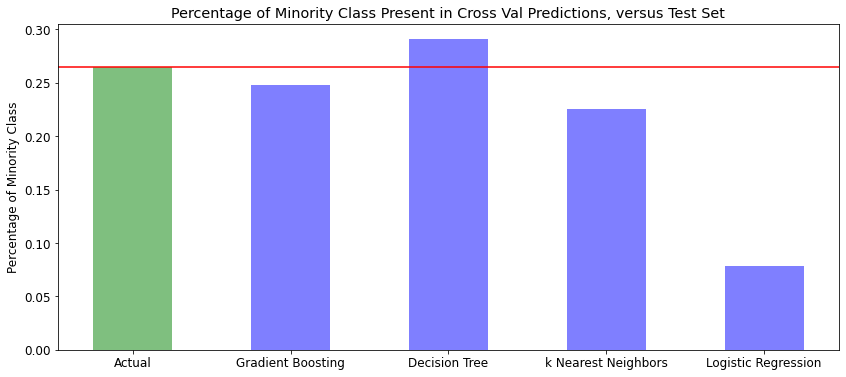

In [38]:
labels =  ['Actual'] + list(xval_results['Classifier'].values)
results = [min_class] + list(xval_results['Predicted Minority'])
plt.figure(figsize=(14,6))
plt.rc('font', size=12) 
plt.bar(labels, results, width=0.5, color=['green', 'blue', 'blue','blue','blue'],alpha=0.5)
plt.axhline(min_class, color='red')
plt.ylabel('Percentage of Minority Class')
plt.title("Percentage of Minority Class Present in Cross Val Predictions, versus Test Set")
plt.show()

Cross validation has produced quite drastically different results to our hold out testing. In averaging the ten scores from the 10 folds, decision tree is now slightly over-predicting for the minority class. Gradient Boosting has performed rather well. Logistic regression remains the worst performer with regards to bias. 

### Rectifying bias: strategy

When considering our previous results, the best performing classifier is Graident Boosting. Gradient Boosting is an ensemble classifier, and I decided to see if ensemble methods could deal better with bias in general, without having to upsample or downsample the data. 

## Gradient Boosting

Gradient boosting is an ensemble approach we have already used. It uses gradient descent to minimise error the the next tree (classifier) generated. We saw in cross validation that Gradient Descent was performing quite well without having tuned the hyper parameters. In order to improve results, I will be using a grid search.  

In [50]:
param_grid={'learning_rate':[0.1, 0.15, 0.2, 0.3], 
            'n_estimators': list(range(50,250, 20)), 
            'criterion': ['friedman_mse', 'mse', ',mae'],
           'min_samples_split': list(range(2, 10)), 
           'min_samples_leaf': list(range(1,10))}

In [68]:
my_tuned_model = GridSearchCV(GradientBoostingClassifier(random_state=0), param_grid, cv=10, verbose = 1, n_jobs = -1)


In [64]:
GBC = GradientBoostingClassifier(random_state=0).set_params(**my_tuned_model.best_params_)
model_results2 = pd.DataFrame(columns=['Classifier', 'Accuracy','Bias','Predicted Minority', 'F1', 
                                      'Precision', 'Recall', 'False Positive', 'BER', 'Confusion Matrix'])
model_results2.loc[0] = ['Gradient Boosting'] + train_model(my_tuned_model, X_train, X_test, y_train, y_test)

Fitting 10 folds for each of 8640 candidates, totalling 86400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1480 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 2380 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 3480 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 4780 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 6280 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 7980 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9880 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 11980 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 14280 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 16780 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 19480 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 22380 tasks 

In [72]:
model_results2

,Classifier,Accuracy,Bias,Predicted Minority,F1,Precision,Recall,False Positive,BER,Confusion Matrix
0,Gradient Boosting,0.64,0.47,0.19,0.75,0.67,0.85,0.75,0.45,"[[9, 27], [10, 56]]"


In [69]:
import matplotlib.patches as mpatches

# This function will be used to plot the differing results generated by the singular
# classifiers versus the ensembles.
def plot_difference(i, title):
    accuracy = [model_results.iloc[i]['Accuracy'], model_results2.iloc[i]['Accuracy']]
    bias = [model_results.iloc[i]['Bias'], model_results2.iloc[i]['Bias']]
    precision = [model_results.iloc[i]['Precision'], model_results2.iloc[i]['Precision']]
    recall = [model_results.iloc[i]['Recall'], model_results2.iloc[i]['Recall']]
    X = np.arange(2)
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(X + 0.00, accuracy, color = 'b', width = 0.1, label="Accuracy")
    ax.bar(X + 0.1, bias, color = 'g', width = 0.1, label = "Bias")
    ax.bar(X + 0.20, precision, color = 'r', width = 0.1, label = "Precision")
    ax.bar(X + 0.30, recall, color = 'y', width = 0.1, label = "Recall")
    r = mpatches.Patch(color='red', label='Precision')
    b = mpatches.Patch(color='blue', label='Accuracy')
    y = mpatches.Patch(color='yellow', label='Recall')
    g = mpatches.Patch(color='green', label='Bias')
    plt.legend(handles=[r,b,y,g])
    plt.title(title)


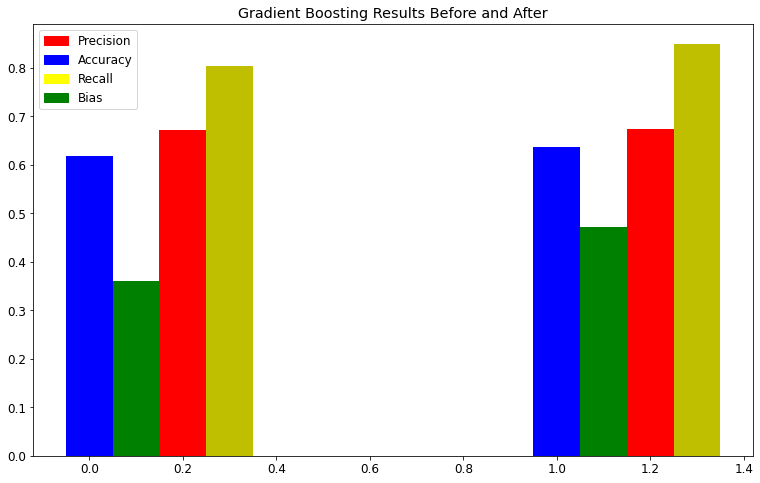

In [70]:
plot_difference(0, 'Gradient Boosting Results Before and After')

Unfortunately, our strategy here has been unsuccessful. Although we see a small increase in accuracy, and a more significant increase in Recall, bias has also increased in the tuned model. 

## Random Forest

A random forest, as the name may suggest, is constructed from a multitude of decision trees, and I will hence be comparing it to the results produced by the decision tree in section 1. Random Forests also give you the opportunity to manually weight the potential classifications, we will again use gridsearch here to find optimal weights. 

In [75]:
from sklearn.ensemble import RandomForestClassifier
param_grid={'class_weight':[{'L5':w, 'GE5':1} for w in list(range(1,300))]}


In [77]:
my_tuned_model = GridSearchCV(RandomForestClassifier(random_state = 0), param_grid, cv=5, verbose = 1, n_jobs = -1)


In [78]:
model_results2.loc[1] = ['RFC'] + train_model(my_tuned_model, X_train, X_test, y_train, y_test)
model_results2

Fitting 5 folds for each of 299 candidates, totalling 1495 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 1495 out of 1495 | elapsed:   27.4s finished


,Classifier,Accuracy,Bias,Predicted Minority,F1,Precision,Recall,False Positive,BER,Confusion Matrix
0,Gradient Boosting,0.64,0.47,0.19,0.75,0.67,0.85,0.75,0.45,"[[9, 27], [10, 56]]"
1,RFC,0.66,0.58,0.15,0.77,0.68,0.89,0.78,0.44,"[[8, 28], [7, 59]]"


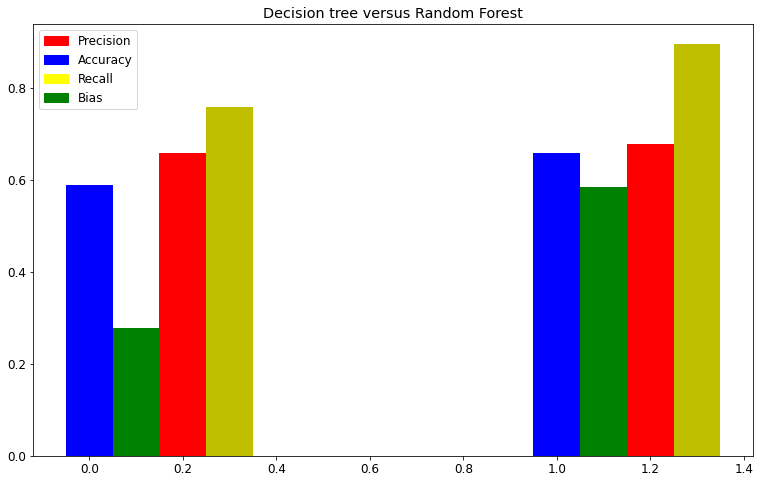

In [79]:
plot_difference(1, 'Decision tree versus Random Forest')

Again, the tuned ensemble does not deal well with bias here. Accuracy has risen, as has recall, but bias has jumped significantly between the use of a simple decision tree and the random forest. 

## KNN - Random Subspace Bagging

Bagging, or bootstrap aggregating, is an ensemble technique used to improve stability and accuracy in algorithms. The idea of bagging is to essentially train a number of classifiers on different subsets of the training data. When it comes to KNN, bootstrap resampling does not produce the wished-for diversity, this is because k-NN is a stable classifier. Instead we have to use random subspace bagging to generate diversity.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state=1)
results = []
# Here we are trying different values for the maximum_features value, while also trying different 
# numbers of estimators. At each iteration, if we have improved on bias, we discard the previous
# results
i = 0.05
while i < 1:
    new = (find_best_n(i, X_train, X_test, y_train, y_test, 2, 50))
    if len(results) == 0:
        results.append(new)
    else:
        if results[0][2] < new[2]:
            results = []
            results.append(new)
        if results[0][2] == new[2]:
            results.append(new)
    i += 0.05

In [30]:
# The results here have the best potential bias, we now sort via accuracy
# and take the last item on the list. 
results.sort(key=lambda x: x[2])
m = results[-1][0]
n = results[-1][1]

In [83]:
from sklearn.ensemble import BaggingClassifier

kNN = KNeighborsClassifier(n_neighbors=3)  
random_SS_kNN = BaggingClassifier(kNN, 
                            n_estimators = 20,
                            max_samples=1.0, 
                            random_state=3)
model_results2.loc[2] = ['SS_kNN'] + train_model(random_SS_kNN, X_train, X_test, y_train, y_test)
model_results2

,Classifier,Accuracy,Bias,Predicted Minority,F1,Precision,Recall,False Positive,BER,Confusion Matrix
0,Gradient Boosting,0.64,0.47,0.19,0.75,0.67,0.85,0.75,0.45,"[[9, 27], [10, 56]]"
1,RFC,0.66,0.58,0.15,0.77,0.68,0.89,0.78,0.44,"[[8, 28], [7, 59]]"
2,SS_kNN,0.65,0.56,0.16,0.76,0.67,0.88,0.78,0.45,"[[8, 28], [8, 58]]"


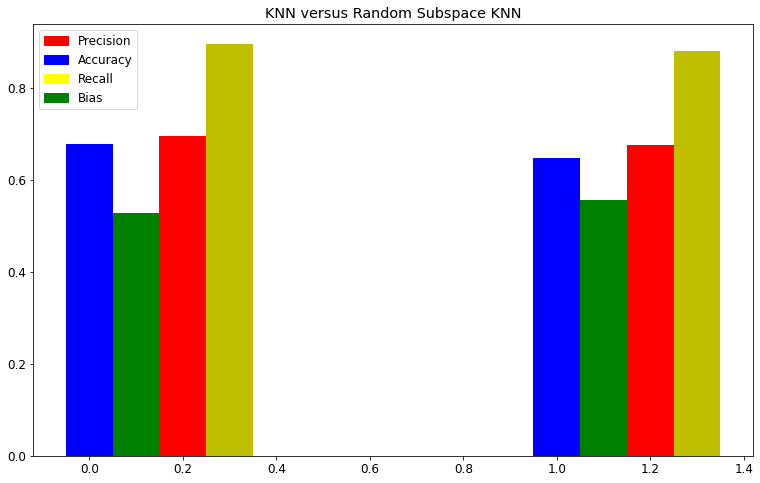

In [84]:
plot_difference(2, 'KNN versus Random Subspace KNN')

Unfortunately the only gain we see here is in bias. Accuracy has even dropped a little with the bagged kNN. 

### Bagged Logistic Regression

For the final model, I again decided to use bagging. This time we will be using "traditional" bagging, as opposed to subspace bagging. I have also weighted the classes by hand this time, as using a function was proving extremely slow and computationally heavy. 

In [86]:
def weighted_train_model(model, X_train, X_test, y_train, y_test):
    sample_weights = np.zeros(len(y_train))
    sample_weights[y_train == 'GE5'] = 1
    sample_weights[y_train == 'L5'] = 1.9
    y_pred = model.fit(X_train, y_train, sample_weights).predict(X_test)
    return (evaluate_model(y_pred, y_test))


In [87]:
BLR = BaggingClassifier(LogisticRegression(max_iter=10000, solver = 'sag', random_state=0), 
                      n_estimators=10, 
                      bootstrap = True, random_state = 0)
model_results2.loc[3] = ['BLR'] + weighted_train_model(BLR, X_train, X_test, y_train, y_test)
model_results2


,Classifier,Accuracy,Bias,Predicted Minority,F1,Precision,Recall,False Positive,BER,Confusion Matrix
0,Gradient Boosting,0.64,0.47,0.19,0.75,0.67,0.85,0.75,0.45,"[[9, 27], [10, 56]]"
1,RFC,0.66,0.58,0.15,0.77,0.68,0.89,0.78,0.44,"[[8, 28], [7, 59]]"
2,SS_kNN,0.65,0.56,0.16,0.76,0.67,0.88,0.78,0.45,"[[8, 28], [8, 58]]"
3,BLR,0.66,0.53,0.17,0.77,0.68,0.88,0.75,0.44,"[[9, 27], [8, 58]]"


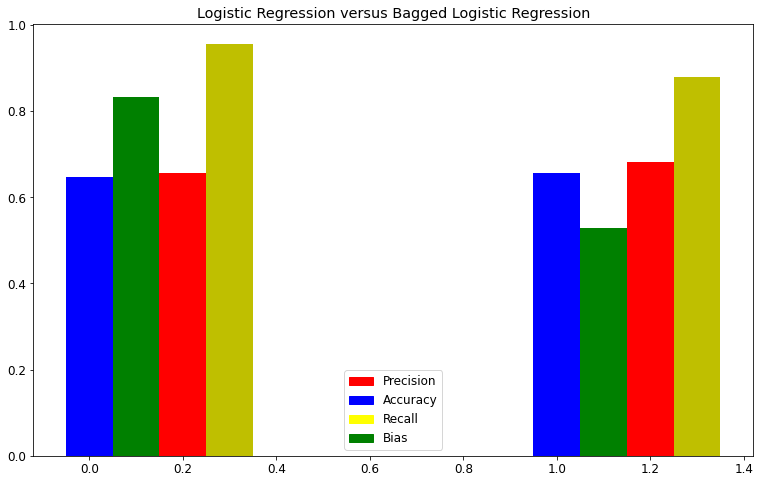

In [88]:
plot_difference(3, 'Logistic Regression versus Bagged Logistic Regression')

This is the most successful result. Accuracy has remained steady and bias has significantly dropped. But, given that I have hand weighted the classes, one must wonder if my own bias has been inserted. I have decided to explore this strategy further on another dataset. 

### Creditcard Fraud Dataset

In [90]:
fraud = pd.read_csv('creditcardv2.csv')

In [91]:
vc = fraud['Class'].value_counts()
vc

0    2008
1     492
Name: Class, dtype: int64

In [92]:
y2 = fraud.pop('Class').values
X2 = fraud.values
X2.shape, y2.shape

((2500, 31), (2500,))

In [93]:
min_class = y2.sum()/len(y2)
print("Minority class : %0.2f" % min_class)

Minority class : 0.20


In [94]:
def evaluate_model(y_pred, y_test):
    pred_pos = y_pred.sum()
    pred_neg = len(y_pred) - pred_pos
    test_pos = y_test.sum()
    bias = 1 - (pred_pos / test_pos)
    accuracy = accuracy_score(y_test, y_pred)
    minority_percent = pred_pos/len(y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    precision = confusion[1][1] / (confusion[1][1] + confusion[0][1])
    recall = confusion[1][1] / (confusion[1][1] + confusion[1][0])
    f1 = f1_score(y_test, y_pred)
    true_negative = confusion[0][1] / (confusion[0][1] + confusion[0][1])
    false_positive = confusion[0][1] / (confusion[0][1] + confusion[0][0])
    false_negative = confusion[1][0] / (confusion[1][0] + confusion[1][1])
    BER = statistics.mean([false_positive, false_negative])
    return [accuracy, bias, minority_percent, f1, precision, recall, false_positive, BER, confusion]

In [95]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 1/3, random_state=0)
minority_class = y_test2.sum()/len(y_test2)
minority_class
LR = LogisticRegression(max_iter=10000, solver = 'sag')
model_resultsb = pd.DataFrame(columns=['Classifier', 'Accuracy','Bias','Predicted Minority', 'F1', 
                                       'Precision', 'Recall', 'False Positive', 'BER', 'Confusion Matrix'])

model_results.loc[4] = ['Logistic Regression 2'] + train_model(LR, X_train2, X_test2, y_train2, y_test2)
model_results

,Classifier,Accuracy,Bias,Predicted Minority,F1,Precision,Recall,False Positive,BER,Confusion Matrix
0,Gradient Boosting,0.62,0.36,0.23,0.73,0.67,0.80,0.72,0.46,"[[10, 26], [13, 53]]"
1,Decision Tree,0.59,0.28,0.25,0.70,0.66,0.76,0.72,0.48,"[[10, 26], [16, 50]]"
2,k Nearest Neighbors,0.68,0.53,0.17,0.78,0.69,0.89,0.72,0.41,"[[10, 26], [7, 59]]"
3,Logistic Regression,0.65,0.83,0.06,0.78,0.66,0.95,0.92,0.48,"[[3, 33], [3, 63]]"
4,Logistic Regression 2,0.81,0.99,0.00,0.01,0.50,0.01,0.00,0.50,"[[674, 1], [158, 1]]"


Simple logistic regression is proving even more unsuccessful here than it did with the previous data set. Accuracy is high, but bias is at an incredible 0.99, or 99%. The minority class in this data set corresponds to the positive class, hence why we see a false positive rate of zero. The classifier is making almost no positive classifications, so it is impossible to incorrectly classify an example as positive. 

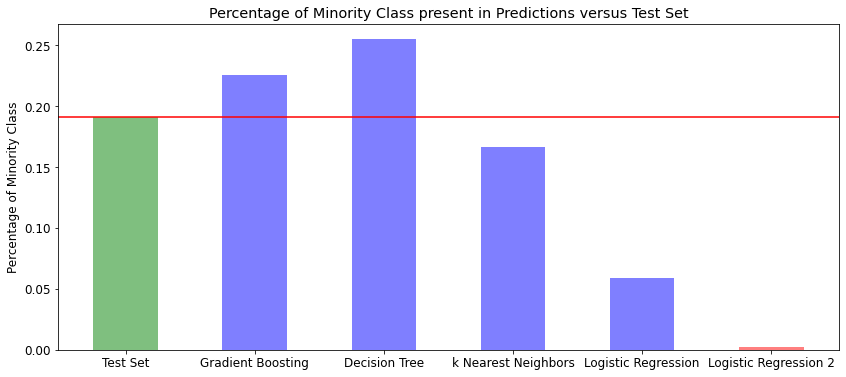

In [96]:
import matplotlib.pyplot as plt 
%matplotlib inline 
labels =  ['Test Set'] + list(model_results['Classifier'].values)
results = [minority_class] + list(model_results['Predicted Minority'].values)
plt.figure(figsize=(14,6))
plt.rc('font', size=12) 
plt.bar(labels, results, width=0.5, color=['green', 'blue', 'blue','blue','blue', 'red'],alpha=0.5)
plt.axhline(y=minority_class, color='red')
plt.ylabel('Percentage of Minority Class')
plt.title("Percentage of Minority Class present in Predictions versus Test Set")
plt.show()

In [97]:
def weighted_train_model(model, X_train, X_test, y_train, y_test):
    sample_weights = np.zeros(len(y_train))
    sample_weights[y_train == 0] = 1
    sample_weights[y_train == 1] = 4.25
    y_pred = model.fit(X_train, y_train, sample_weights).predict(X_test)
    return (evaluate_model(y_pred, y_test))

In [98]:
BLR = BaggingClassifier(LogisticRegression(max_iter=100000, solver = 'sag', random_state=0), 
                      n_estimators=12, 
                      bootstrap = True, random_state = 0)
model_results2.loc[4] = ['Bagged Logistic Regression 2'] + weighted_train_model(BLR, X_train2, X_test2, y_train2, y_test2)
model_results2

,Classifier,Accuracy,Bias,Predicted Minority,F1,Precision,Recall,False Positive,BER,Confusion Matrix
0,Gradient Boosting,0.64,0.47,0.19,0.75,0.67,0.85,0.75,0.45,"[[9, 27], [10, 56]]"
1,RFC,0.66,0.58,0.15,0.77,0.68,0.89,0.78,0.44,"[[8, 28], [7, 59]]"
2,SS_kNN,0.65,0.56,0.16,0.76,0.67,0.88,0.78,0.45,"[[8, 28], [8, 58]]"
3,BLR,0.66,0.53,0.17,0.77,0.68,0.88,0.75,0.44,"[[9, 27], [8, 58]]"
4,Bagged Logistic Regression 2,0.85,0.33,0.13,0.52,0.65,0.43,0.05,0.31,"[[638, 37], [90, 69]]"


As in the previous example, I weighted the classes by hand to favor the minority class.

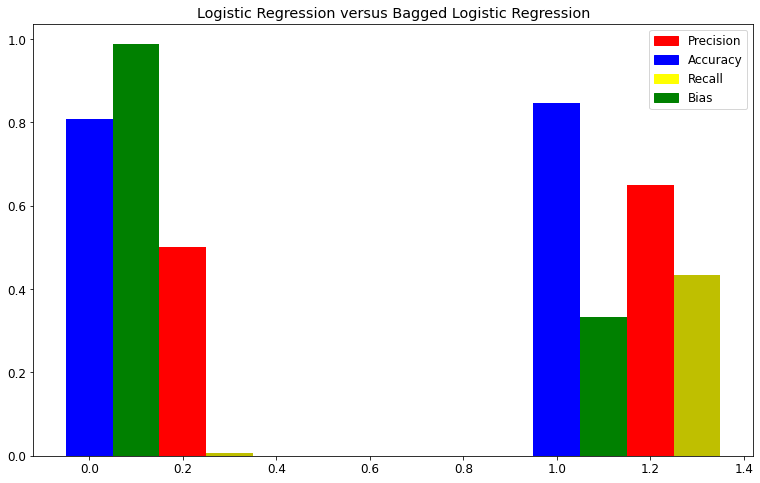

In [99]:
plot_difference(4, 'Logistic Regression versus Bagged Logistic Regression')

Here it seems, our ensemble method wins out again. Accuracy has held steady, bias has fallen, precision has grown, and recall has climbed from almost 0 to around .5. But one must wonder how this technique will hold up to cross validation?

### Conclusions

Ensembles as an entity do not seem to resolve the issue of an unbalanced dataset. My best results came with manual intervention, hand weighting the classes to favor the minority class. On a superficial level, this strategy for addressing bias seemed to be extremely successful. Bias fell greatly, and accuracy, recall and precision remained relatively stable. But, as I looked closer at my results I came to suspect that my approach was too simplistic, and that these results were perhaps too good to be true. After reverifying my models with cross validation, it seems that they had all fallen ill to over-fitting. 

For instance, if we take my modified Gradient Boosting Classifier, and cross validate it, we can see that bias climbs right back up to 69%. If I cross-validate my Random Forest Classifier, bias becomes negative, meaning the classifier is over predicting the minority class. If I then cross validate a Random Forest Classifier with the default variables untouched, we can see it produces a result with only 0.26 bias, and an accuracy score of 0.68.

It seems that Ensembles are definitely a valid tool for dealing with imbalanced data but I did take a wrong turn with my simplistic approach to parameter selection. I imagine that parameter tuning can also be very successful in assisting with correcting balance, but that was not the case here. 

In [102]:
xval_results2 = pd.DataFrame(columns=['Classifier','Bias', 'Accuracy', 'Predicted Minority', 'Precision',
                                    'Recall', 'F1', 'False Positive Rate', 'BER'])

cv_results = cross_validate(BLR, X, y, cv= folds,scoring=scoring, return_train_score=False, 
                                 verbose = v, n_jobs = -1)
xval_results2.loc[0] = model_results2.loc[4]
xval_results2.loc[1] = ['BLR_XVAL'] + evaluate_xval(cv_results)

In [103]:
xval_results2

,Classifier,Bias,Accuracy,Predicted Minority,Precision,Recall,F1,False Positive Rate,BER
0,Bagged Logistic Regression 2,0.33,0.85,0.13,0.65,0.43,0.52,nan,0.31
1,BLR_XVAL,0.69,0.75,0.08,0.10,0.96,0.18,0.81,0.43


We can see that when th